In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = 'archiveFaces/face_age'
output_dir = 'archiveFaces/output'

train_menor_dir = os.path.join(output_dir, 'train', 'menor_de_edad')
val_menor_dir = os.path.join(output_dir, 'val', 'menor_de_edad')
train_mayor_dir = os.path.join(output_dir, 'train', 'mayor_de_edad')
val_mayor_dir = os.path.join(output_dir, 'val', 'mayor_de_edad')
os.makedirs(train_menor_dir, exist_ok=True)
os.makedirs(val_menor_dir, exist_ok=True)
os.makedirs(train_mayor_dir, exist_ok=True)
os.makedirs(val_mayor_dir, exist_ok=True)


def split_and_copy_files(src_dir, train_dir, val_dir, split_ratio=0.2):
    all_files = [os.path.join(src_dir, f) for f in os.listdir(
        src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    if len(all_files) > 1:
        train_files, val_files = train_test_split(
            all_files, test_size=split_ratio, random_state=42)
    else:
        train_files = all_files
        val_files = []

    for file in train_files:
        shutil.copy(file, train_dir)

    for file in val_files:
        shutil.copy(file, val_dir)


for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        age = int(folder)

        if age < 18:
            split_and_copy_files(folder_path, train_menor_dir, val_menor_dir)
        else:
            split_and_copy_files(folder_path, train_mayor_dir, val_mayor_dir)

print("Clasificación y división completadas.")

Clasificación y división completadas.


In [6]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred > 0.5, tf.bool)
        self.true_negatives.assign_add(tf.reduce_sum(
            tf.cast(tf.logical_not(y_true) & tf.logical_not(y_pred), tf.float32)))
        self.false_positives.assign_add(tf.reduce_sum(
            tf.cast(tf.logical_not(y_true) & y_pred, tf.float32)))

    def result(self):
        specificity = self.true_negatives / \
            (self.true_negatives + self.false_positives)
        return specificity

    def reset_state(self):
        self.true_negatives.assign(0)
        self.false_positives.assign(0)

# Definir la métrica F1-Score


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [3]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Configuración
img_height = 200
img_width = 200
num_classes = 1  # Clasificación binaria


def set_seed(seed=5):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)


set_seed(8)

# Función para crear el modelo


def create_model(learning_rate, use_batch_norm):
    inputs = Input(shape=(img_height, img_width, 3))
    x = inputs

    # 1er bloque convolucional
    for filters in [32, 64, 128, 256]:
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

    # GlobalAveragePooling
    x = GlobalAveragePooling2D()(x)

    # Capa densa oculta
    x = Dense(32, activation='relu')(x)
    if use_batch_norm:
        x = BatchNormalization()(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Crear modelo
    model = Model(inputs=inputs, outputs=outputs)

    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            Specificity(),
            F1Score(),
            AUC(name='auc'),
            TruePositives(name='true_positives'),
            TrueNegatives(name='true_negatives'),
            FalsePositives(name='false_positives'),
            FalseNegatives(name='false_negatives')
        ]
    )
    return model


# Directorios de datos
train_dir = 'archiveFaces/output/train'
val_dir = 'archiveFaces/output/val'

# Generadores de datos
# train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_augmented = ImageDataGenerator( #Transformación 1
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# train_datagen = ImageDataGenerator( #Transformación 2
#     rescale=1./255,  # Normalizar los píxeles al rango [0, 1]
#     rotation_range=20,

#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(img_height, img_width),
#     batch_size=32,
#     class_mode='binary'
# )

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

# Parámetros para probar
# learning_rates = [0.01, 0.001, 0.0005, 0.0001]
# batch_sizes = [16, 32, 64]
# batch_norm_options = [True, False]

# learning_rates = [0.0001]
# batch_sizes = [16]
# batch_norm_options = [True]


learning_rates = []
batch_sizes = []
batch_norm_options = []


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('mejor_modelo.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)


# Entrenamiento de los modelos
for lr in learning_rates:
    for batch_size in batch_sizes:
        for use_batch_norm in batch_norm_options:
            model_name = f"model_lr_{lr}_batch_{batch_size}_batchnorm_{use_batch_norm}"
            model_path = f"{model_name}.h5"
            history_path = f"{model_name}_history.npy"

            if os.path.exists(model_path) and os.path.exists(history_path):
                print(f"{model_name} ya existe. Saltando entrenamiento.")
                continue

            print(f"Entrenando {model_name}...")

            model = create_model(lr, use_batch_norm)
            train_generator_augmented.batch_size = batch_size
            val_generator.batch_size = batch_size

            history = model.fit(
                train_generator_augmented,
                epochs=150,  # Aumenta el número de épocas si es necesario
                validation_data=val_generator,
                callbacks=[early_stopping, reduce_lr,model_checkpoint]
            )

            # Guardar el modelo entrenado
            model.save(model_path)

            # Guardar el historial de entrenamiento
            np.save(history_path, history.history)

            print(f"{model_name} entrenado y guardado.")

print("Entrenamiento completado.")

Found 7780 images belonging to 2 classes.
Found 1998 images belonging to 2 classes.
Entrenamiento completado.


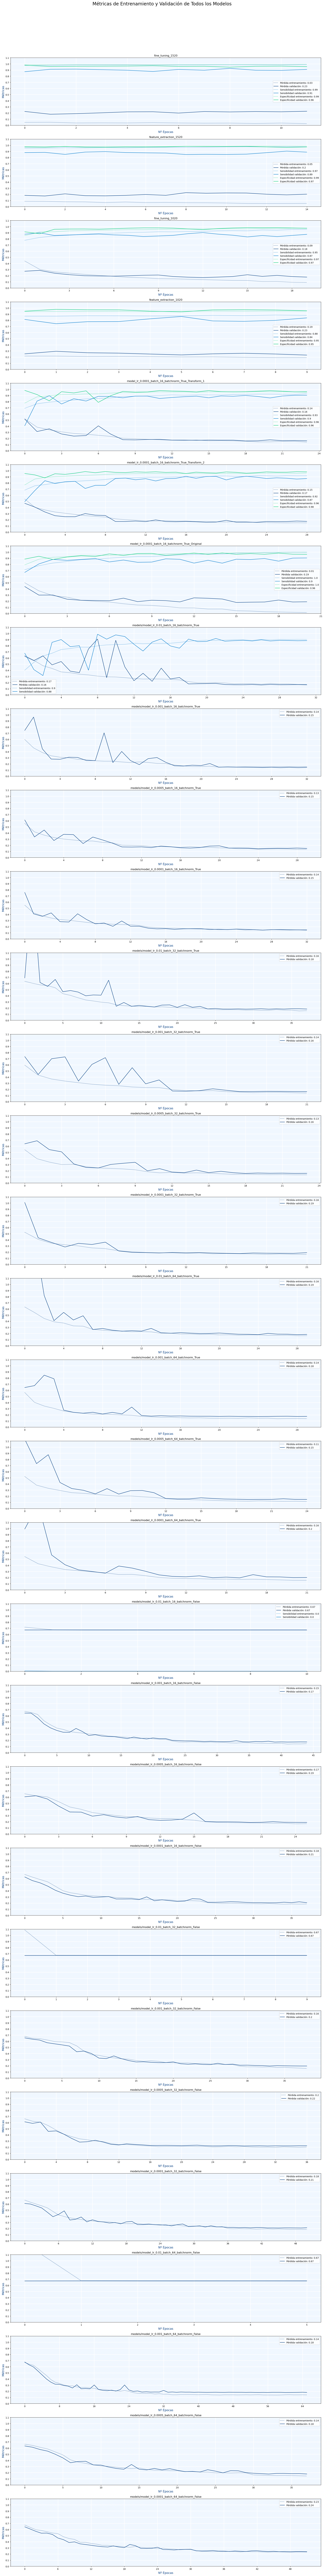

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator

# Lista de nombres de los modelos entrenados
model_names = [
    "fine_tuning_1520",
    "feature_extraction_1520",
    "fine_tuning_1020",
    "feature_extraction_1020",
    "model_lr_0.0001_batch_16_batchnorm_True_Transform_1",

    "model_lr_0.0001_batch_16_batchnorm_True_Transform_2",
    "model_lr_0.0001_batch_16_batchnorm_True_Original",
    "models/model_lr_0.01_batch_16_batchnorm_True",
    "models/model_lr_0.001_batch_16_batchnorm_True",
    "models/model_lr_0.0005_batch_16_batchnorm_True",
    "models/model_lr_0.0001_batch_16_batchnorm_True",
    "models/model_lr_0.01_batch_32_batchnorm_True",
    "models/model_lr_0.001_batch_32_batchnorm_True",
    "models/model_lr_0.0005_batch_32_batchnorm_True",
    "models/model_lr_0.0001_batch_32_batchnorm_True",
    "models/model_lr_0.01_batch_64_batchnorm_True",
    "models/model_lr_0.001_batch_64_batchnorm_True",
    "models/model_lr_0.0005_batch_64_batchnorm_True",
    "models/model_lr_0.0001_batch_64_batchnorm_True",
    "models/model_lr_0.01_batch_16_batchnorm_False",
    "models/model_lr_0.001_batch_16_batchnorm_False",
    "models/model_lr_0.0005_batch_16_batchnorm_False",
    "models/model_lr_0.0001_batch_16_batchnorm_False",
    "models/model_lr_0.01_batch_32_batchnorm_False",
    "models/model_lr_0.001_batch_32_batchnorm_False",
    "models/model_lr_0.0005_batch_32_batchnorm_False",
    "models/model_lr_0.0001_batch_32_batchnorm_False",
    "models/model_lr_0.01_batch_64_batchnorm_False",
    "models/model_lr_0.001_batch_64_batchnorm_False",
    "models/model_lr_0.0005_batch_64_batchnorm_False",
    "models/model_lr_0.0001_batch_64_batchnorm_False"
]

# Función para cargar los historiales de entrenamiento


def load_history(model_name):
    return np.load(f"{model_name}_history.npy", allow_pickle=True).item()

# Función para graficar las métricas con estilo mejorado


def plot_metrics(axes, history, title):
    # Graficar pérdida
    loss_entrenamiento = round(history['loss'][-1], 2)
    loss_validacion = round(history['val_loss'][-1], 2)
    axes.plot(history['loss'], linestyle="dotted",
              label="Pérdida entrenamiento: " + str(loss_entrenamiento), c="#003B80")
    axes.plot(history['val_loss'], linestyle="solid",
              label="Pérdida validación: " + str(loss_validacion), c="#003B80")

    # Graficar sensibilidad (recall)
    if 'recall' in history and 'val_recall' in history:
        recall_entrenamiento = round(history['recall'][-1], 2)
        recall_validacion = round(history['val_recall'][-1], 2)
        axes.plot(history['recall'], linestyle="dotted",
                  label="Sensibilidad entrenamiento: " + str(recall_entrenamiento), c="#007ACC")
        axes.plot(history['val_recall'], linestyle="solid",
                  label="Sensibilidad validación: " + str(recall_validacion), c="#007ACC")

    # Graficar especificidad
    if 'specificity' in history and 'val_specificity' in history:
        specificity_entrenamiento = round(history['specificity'][-1], 2)
        specificity_validacion = round(history['val_specificity'][-1], 2)
        axes.plot(history['specificity'], linestyle="dotted",
                  label="Especificidad entrenamiento: " + str(specificity_entrenamiento), c="#00CC74")
        axes.plot(history['val_specificity'], linestyle="solid",
                  label="Especificidad validación: " + str(specificity_validacion), c="#00CC74")

    # Configuración de los ejes y la gráfica
    axes.set_xlabel('Nº Épocas', fontsize=13, color="#003B80")
    axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    axes.set_ylabel('Métricas', fontsize=13, color="#003B80")
    axes.set_ylim(ymin=0, ymax=1.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.1))
    axes.set_title(title)
    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both',
              color="#FFFFFF", linewidth=2)
    axes.legend()


# Cargar todos los historiales de entrenamiento
histories = [load_history(model_name) for model_name in model_names if os.path.exists(
    f"{model_name}_history.npy")]

# Graficar las métricas de todos los modelos
figure = plt.figure(figsize=(20, 5 * len(histories)))
index = 1

for history, model_name in zip(histories, model_names):
    axes = figure.add_subplot(len(histories), 1, index)
    plot_metrics(axes, history, model_name)
    index += 1

plt.tight_layout()
plt.suptitle(
    'Métricas de Entrenamiento y Validación de Todos los Modelos', y=1.02, fontsize=20)
plt.show()

In [7]:
history = load_history(model_name)
print(history.keys())

dict_keys(['loss', 'accuracy', 'precision_5', 'recall_5', 'val_loss', 'val_accuracy', 'val_precision_5', 'val_recall_5', 'lr'])


In [13]:
history = load_history("model_lr_0.0001_batch_16_batchnorm_True_Transform_1")
print(history.keys())

#   "model_lr_0.0001_batch_16_batchnorm_True_Transform_1",
#     "model_lr_0.0001_batch_16_batchnorm_True_Transform_2",
#     "model_lr_0.0001_batch_16_batchnorm_True_Original",

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_specificity', 'val_f1_score', 'val_auc', 'val_true_positives', 'val_true_negatives', 'val_false_positives', 'val_false_negatives', 'lr'])


In [18]:
import pandas as pd
import re

results = []

for model_name in model_names:
    history = load_history(model_name)
    if history:  # Asegurarse de que history no es None
        last_epoch = len(history['val_loss']) - 1
        result = {
            'Modelo': model_name,
            'Pérdida de Validación': history['val_loss'][last_epoch],
            'Precisión de Validación': history['val_accuracy'][last_epoch]
        }
        
        # Buscar dinámicamente las claves de recall y precision
        recall_keys = [key for key in history.keys() if re.match(r'val_recall(?:_\d+)?', key)]
        precision_keys = [key for key in history.keys() if re.match(r'val_precision(?:_\d+)?', key)]
        
        if recall_keys:
            result['Sensibilidad de Validación'] = history[recall_keys[0]][last_epoch]
        else:
            result['Sensibilidad de Validación'] = None  # O puedes usar np.nan para representar datos faltantes

        if precision_keys:
            result['Precisión de Validación'] = history[precision_keys[0]][last_epoch]
        else:
            result['Precisión de Validación'] = None  # O puedes usar np.nan para representar datos faltantes

        results.append(result)

# Convertir los resultados en un DataFrame para fácil manipulación y visualización
df_results = pd.DataFrame(results)
df_results.sort_values(by='Pérdida de Validación', ascending=True, inplace=True)

df_results

,Modelo,Pérdida de Validación,Precisión de Validación,Sensibilidad de Validación
6,models/model_lr_0.0001_batch_16_batchnorm_True,0.146844,0.954545,0.902655
13,models/model_lr_0.0005_batch_64_batchnorm_True,0.147781,0.952191,0.906448
5,models/model_lr_0.0005_batch_16_batchnorm_True,0.148178,0.959294,0.893805
4,models/model_lr_0.001_batch_16_batchnorm_True,0.148910,0.954606,0.903919
9,models/model_lr_0.0005_batch_32_batchnorm_True,0.157611,0.948925,0.892541
0,model_lr_0.0001_batch_16_batchnorm_True_Transf...,0.161209,0.932203,0.903919
3,models/model_lr_0.01_batch_16_batchnorm_True,0.163113,0.961486,0.883692
8,models/model_lr_0.001_batch_32_batchnorm_True,0.163572,0.942667,0.893805
16,models/model_lr_0.001_batch_16_batchnorm_False,0.173345,0.948510,0.884956
1,model_lr_0.0001_batch_16_batchnorm_True_Transf...,0.173967,0.967742,0.872313


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Definir el modelo base usando MobileNetV2
base_model = MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Añadir capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    Specificity(),
    F1Score(),
    AUC(name='auc'),
    TruePositives(name='true_positives'),
    TrueNegatives(name='true_negatives'),
    FalsePositives(name='false_positives'),
    FalseNegatives(name='false_negatives')
])

# Definir callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    'mejor_modelo.h5', save_best_only=True, monitor='val_loss', mode='min')

# Entrenamiento para la extracción de características
print("Iniciando la extracción de características...")
history_feature_extraction = model.fit(
    train_generator_augmented,
    epochs=20,  # Ajustar según sea necesario
    validation_data=val_generator
)

# Guardar el historial de la extracción de características
np.save('feature_extraction_1520_history.npy',
        history_feature_extraction.history)

# Descongelar algunas capas superiores del modelo base para el ajuste fino
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Recompilar el modelo para el ajuste fino
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=[
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall'),
    Specificity(),
    F1Score(),
    AUC(name='auc'),
    TruePositives(name='true_positives'),
    TrueNegatives(name='true_negatives'),
    FalsePositives(name='false_positives'),
    FalseNegatives(name='false_negatives')
])

# Entrenamiento para el ajuste fino
print("Iniciando el ajuste fino...")
history_fine_tuning = model.fit(
    train_generator_augmented,
    epochs=20,  # Ajustar según sea necesario
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Guardar el historial del ajuste fino
np.save('fine_tuning_2020_history.npy', history_fine_tuning.history)

# Guardar el modelo ajustado
model.save('modelo_ajustado_2020.h5')

print("Modelo entrenado y guardado con éxito.")

Iniciando la extracción de características...
Epoch 1/20
132/244 [===============>..............] - ETA: 27s - loss: 0.3207 - accuracy: 0.8594 - precision: 0.8516 - recall: 0.7962 - specificity: 0.9034 - f1_score: 0.8229 - auc: 0.9318 - true_positives: 1371.0000 - true_negatives: 2235.0000 - false_positives: 239.0000 - false_negatives: 351.0000